In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
def load_images_from_folder(folder, num_images_per_class=1800):
    images = []
    labels = []
    for label in os.listdir(folder):
        class_folder = os.path.join(folder, label)
        if not os.path.isdir(class_folder):
            print(f"Skipping non-directory item: {class_folder}")
            continue
        all_images = os.listdir(class_folder)
        if len(all_images) < num_images_per_class:
            print(f"Not enough images in {class_folder}. Found {len(all_images)}, required {num_images_per_class}")
            continue
        selected_images = random.sample(all_images, num_images_per_class)
        for filename in selected_images:
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            img = cv2.resize(img, (256, 256))  # Resizing images to a consistent size 
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [68]:
# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [69]:
# Data Augmentation in Training Transformations 
# added random horizontal flip and random rotations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [93]:
folder = '/Users/raghavsenwal/Downloads/data_256' 
images, labels = load_images_from_folder(folder)
print(f"Loaded {len(images)} images with {len(labels)} labels.")
print(f"Unique labels found: {set(labels)}")

Skipping non-directory item: /Users/raghavsenwal/Downloads/data_256/.DS_Store
Loaded 9000 images with 9000 labels.
Unique labels found: {'HospitalRoom', 'Gymnasium', 'Bar', 'SubwayStation ', 'Restaurant'}


In [71]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [72]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(images, encoded_labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [73]:
# Create datasets
train_dataset = CustomImageDataset(X_train, y_train, transform=train_transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=val_test_transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=val_test_transform)

In [74]:
# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [75]:
# Define the CNN model with batch normalization and Leaky ReLU
class CNNModel(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.LeakyReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.LeakyReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.LeakyReLU()(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 32 * 32)
        x = nn.LeakyReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [76]:
# Initialize the model, loss function, and optimizer
# L2 Regularization: Added weight_decay=1e-4 in the optimizer
model = CNNModel(num_classes=5)
device = torch.device('mps')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization (weight decay)


In [77]:
# Early stopping criteria
patience = 7
# If the validation loss does not improve for patience consecutive epochs, 
# the training stops early
best_val_loss = float('inf')
patience_counter = 0


In [78]:
# Training and validation loop with early stopping
# Implemented early stopping with model checkpoint saving in the training loop
# The early stopping mechanism is implemented to prevent overfitting
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/50, Training Loss: 6.0730, Validation Loss: 1.2886, Validation Accuracy: 47.22%
Epoch 2/50, Training Loss: 1.5436, Validation Loss: 1.2175, Validation Accuracy: 50.00%
Epoch 3/50, Training Loss: 1.4201, Validation Loss: 1.1911, Validation Accuracy: 51.61%
Epoch 4/50, Training Loss: 1.3286, Validation Loss: 1.2112, Validation Accuracy: 51.28%
Epoch 5/50, Training Loss: 1.2715, Validation Loss: 1.0890, Validation Accuracy: 59.22%
Epoch 6/50, Training Loss: 1.2579, Validation Loss: 1.1285, Validation Accuracy: 56.44%
Epoch 7/50, Training Loss: 1.2503, Validation Loss: 1.1226, Validation Accuracy: 57.11%
Epoch 8/50, Training Loss: 1.2457, Validation Loss: 1.0810, Validation Accuracy: 59.61%
Epoch 9/50, Training Loss: 1.2301, Validation Loss: 1.2541, Validation Accuracy: 54.72%
Epoch 10/50, Training Loss: 1.1811, Validation Loss: 1.2560, Validation Accuracy: 53.44%
Epoch 11/50, Training Loss: 1.1506, Validation Loss: 1.0946, Validation Accuracy: 57.83%
Epoch 12/50, Training Loss: 1.

In [89]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [90]:
# Testing the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

In [99]:
# Compute metrics

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {test_loss:.4f}, "
      f"Test Accuracy: {test_accuracy:.2f}%, "
      f"Precision: {precision:.4f}, "
      f"Recall: {recall:.4f}, "
      f"F1 Score: {f1:.4f}")

# Print classification report
class_report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_)
print("\nClassification Report:\n", class_report)

Test Loss: 0.0002, Test Accuracy: 71.21%, Precision: 0.7213, Recall: 0.6972, F1 Score: 0.7028

Classification Report:
                 precision    recall  f1-score   support

           Bar       0.63      0.60      0.61       344
     Gymnasium       0.93      0.67      0.78       400
  HospitalRoom       0.74      0.79      0.77       357
    Restaurant       0.49      0.63      0.55       345
SubwayStation        0.78      0.79      0.79       354

      accuracy                           0.70      1800
     macro avg       0.71      0.70      0.70      1800
  weighted avg       0.72      0.70      0.70      1800



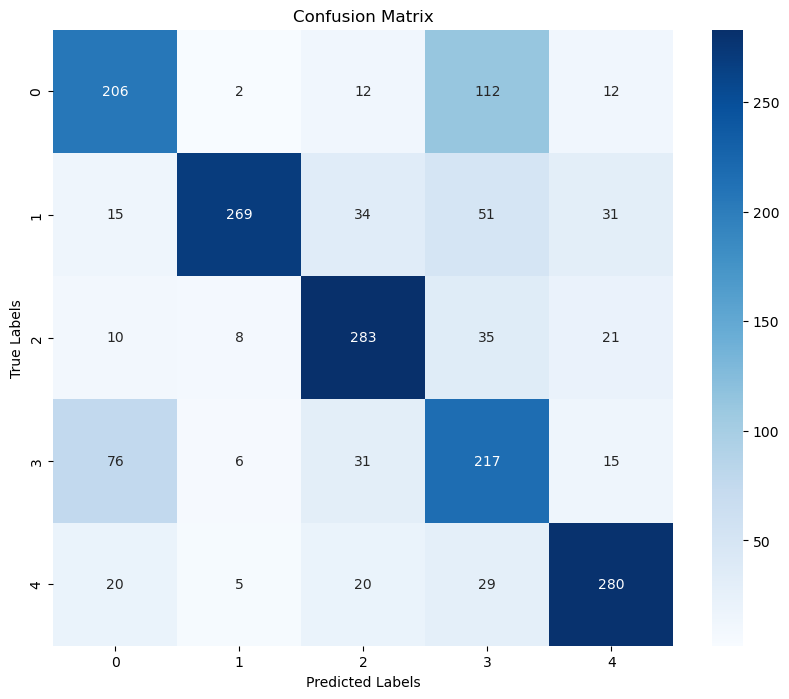

In [94]:
# Compute confusion matrix
# Added Precision, recall, and F1 score calculation after testing
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()